# Multi Layer Perceptron As A Function Approximator

We will utilize a multi layer perceptron (MLP) as a function approximator. 

We are given a dataset $\mathcal{D} = \{(\mathbf{x}_1,\mathbf{y}_1),\cdots,(\mathbf{x}_N,\mathbf{y}_N)\}$ such that $\mathbf{x}_i \in \mathbb{R}^2$ and $\mathbf{y}_i = f(\mathbf{x}_i) \in \mathbb{R}$. We will approximate the function $f(\mathbf{x})$ using an MLP with one hidden-layer of 3 nodes. 

<img src="images/mlp_regression.png" alt="alt text" width="300"/>

## Create Data

In [1]:
import torch

# for reproducibility
torch.manual_seed(23)

# create data
N = 71 # num data points
x1 = torch.linspace(-0.7,0.7,N)
x2 = torch.linspace(-0.7,0.7,N)

# create a mesh-grid
xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')

# make it a 2D array of shape (N,2)
x = torch.stack((torch.reshape(xx1,(-1,)),torch.reshape(xx2,(-1,))),dim=1)
# print(x)

# function f(.)
y = torch.reshape(torch.sqrt(x[:,0]**2 + x[:,1]**2),(-1,1))
# y = torch.reshape(.2*x[:,0] + .8*x[:,1],(-1,1))
# print(y)

### Helper function to plot data

In [2]:
%matplotlib inline
# %matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt


def plot_data(ax,data,target):
    ax.scatter(data[:,0], data[:,1], target)

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')
        
#     ax.set_axisbelow(True)
#     ax.grid(color='gray', linestyle='dashed')
        
        

### Plot the data

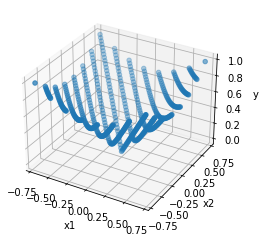

In [3]:
# plot the data
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plot_data(ax, x[::10], y[::10])


## Construct and Train an MLP in PyTorch

### Create a dataset and dataloader

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data

In [5]:
dataset_train = torch.utils.data.TensorDataset(x,y)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=0)

### Constructing the model

In [6]:
class SimpleNN(nn.Module):
    def __init__(self, num_features=1, nonlinearity='relu', initialization='default'):
        super().__init__()
        
        # for reproducibility
        torch.manual_seed(23)
        
        self.nonlinearity = nonlinearity
        
        self.fc1 = nn.Linear(2, num_features, bias=True)
        self.fc2 = nn.Linear(num_features, 1, bias=True)
        
        if initialization == 'normal':
            torch.nn.init.normal_(self.fc1.weight, mean=0.0, std=1.0)
            torch.nn.init.normal_(self.fc1.bias, mean=0.0, std=1.0)
            torch.nn.init.normal_(self.fc2.weight, mean=0.0, std=1.0)
            torch.nn.init.normal_(self.fc2.bias, mean=0.0, std=1.0)
        elif initialization == 'xavier':
            torch.nn.init.xavier_uniform_(self.fc1.weight)
            torch.nn.init.xavier_uniform_(self.fc2.weight)
        elif initialization == 'zeros':
            torch.nn.init.zeros_(self.fc1.weight)
            torch.nn.init.zeros_(self.fc1.bias)
            torch.nn.init.zeros_(self.fc2.weight)
            torch.nn.init.zeros_(self.fc2.bias)
        
    def forward(self, x):
        s1 = self.fc1(x)
        
        if self.nonlinearity == 'relu':
            z1 = F.relu(s1)
        elif self.nonlinearity == 'sigmoid':    
            z1 = torch.sigmoid(s1)
        elif self.nonlinearity == 'tanh': 
            z1 = torch.tanh(s1)
        else:
            z1 = s1
                 
        y = self.fc2(z1)

        
        return s1,z1,y

### Train the model

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Loss Function Performance Analysis

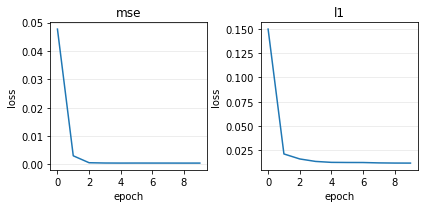

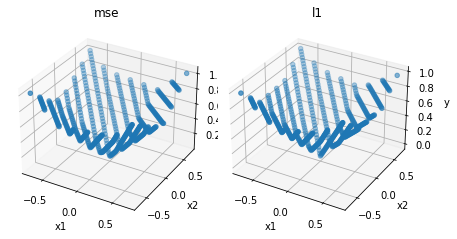

In [8]:
# check model performance with different loss functions
loss_fn_list = ['mse','l1']

# book-keeping for plots
loss_dict = dict()
pred_dict = dict()

for loss_fn in loss_fn_list:
    # get the model using our helper function
    model = SimpleNN(num_features=10, initialization='default')

    # move model to the right device
    model.to(device)

    # define criterion/loss function
    if loss_fn == 'mse':
        criterion = nn.MSELoss()
    elif loss_fn == 'l1':
        criterion = nn.L1Loss()
        

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=3e-3)

    num_epochs = 10
    train_loss_list = []
    for epoch in range(num_epochs):

        # set the model into training mode
        model.train()

        num_predictions = 0
        running_loss = 0.0
        running_num_correct_preds = 0

        for i, (temp_sample, temp_label) in enumerate(dataloader_train):

            # push the mini-batch of data into device
            # if you have a GPU, the data will be pushed into GPU
            temp_sample, temp_label = temp_sample.to(device), temp_label.to(device)


            # 1. feed-forward pass
            _,_,temp_output = model(temp_sample)

            # 2. calculate the loss
            loss = criterion(temp_output, temp_label)

            # 3. clear the gradients
            optimizer.zero_grad()

            # 4. backward pass (back-propagation)
            # to compute gradients of parameters
            loss.backward()

            # 5. update the parameters
            optimizer.step()


            num_samples = temp_label.size(0)
            num_predictions += num_samples

            running_loss += loss.item() * num_samples

        train_loss = running_loss / num_predictions
    #     print(train_loss)


        train_loss_list.append(train_loss)
    
    loss_dict[loss_fn] = train_loss_list
    
    # do inference to see performance
    _,_,temp_output = model(x)
    pred_dict[loss_fn] = temp_output.detach()

# plot the loss throughout training
fig,ax = plt.subplots(1,len(loss_fn_list),figsize=(3*len(loss_fn_list),3))

for i,loss_fn in enumerate(loss_fn_list):
    ax[i].plot(torch.arange(num_epochs),loss_dict[loss_fn])
    ax[i].set_title(loss_fn)
    ax[i].set_xlabel('epoch')
    ax[i].set_ylabel('loss')
    ax[i].set_axisbelow(True)
    ax[i].yaxis.grid(True,which='major',linestyle='-',color='lightgrey',alpha=0.5)

fig.tight_layout()


# plot the data
fig2 = plt.figure()
for i,loss_fn in enumerate(loss_fn_list):
    ax = fig2.add_subplot(1,len(loss_fn_list),i + 1,projection='3d')
    plot_data(ax, x[::10], pred_dict[loss_fn][::10])
    ax.set_title(loss_fn)

fig2.tight_layout()


### Number of Hidden Nodes Performance Analysis

In [ ]:
# check model performance with different number of hidden nodes
num_nodes_list = [3,6,8]

# book-keeping for plots
loss_dict = dict()
pred_dict = dict()

for num_nodes in num_nodes_list:
    # get the model using our helper function
    model = SimpleNN(num_features=num_nodes, initialization='default')

    # move model to the right device
    model.to(device)

    # define criterion/loss function
    criterion = nn.MSELoss()

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=3e-3)

    num_epochs = 10
    train_loss_list = []
    for epoch in range(num_epochs):

        # set the model into training mode
        model.train()

        num_predictions = 0
        running_loss = 0.0
        running_num_correct_preds = 0

        for i, (temp_sample, temp_label) in enumerate(dataloader_train):

            # push the mini-batch of data into device
            # if you have a GPU, the data will be pushed into GPU
            temp_sample, temp_label = temp_sample.to(device), temp_label.to(device)


            # 1. feed-forward pass
            _,_,temp_output = model(temp_sample)

            # 2. calculate the loss
            loss = criterion(temp_output, temp_label)

            # 3. clear the gradients
            optimizer.zero_grad()

            # 4. backward pass (back-propagation)
            # to compute gradients of parameters
            loss.backward()

            # 5. update the parameters
            optimizer.step()


            num_samples = temp_label.size(0)
            num_predictions += num_samples

            running_loss += loss.item() * num_samples

        train_loss = running_loss / num_predictions
    #     print(train_loss)


        train_loss_list.append(train_loss)
    
    loss_dict[num_nodes] = train_loss_list
    
    # do inference to see performance
    _,_,temp_output = model(x)
    pred_dict[num_nodes] = temp_output.detach()

# plot the loss throughout training
fig,ax = plt.subplots(1,len(num_nodes_list),figsize=(3*len(num_nodes_list),3))

for i,num_nodes in enumerate(num_nodes_list):
    ax[i].plot(torch.arange(num_epochs),loss_dict[num_nodes])
    ax[i].set_title(num_nodes)
    ax[i].set_xlabel('epoch')
    ax[i].set_ylabel('loss')
    ax[i].set_axisbelow(True)
    ax[i].yaxis.grid(True,which='major',linestyle='-',color='lightgrey',alpha=0.5)

fig.tight_layout()


# plot the data
fig2 = plt.figure()
for i,num_nodes in enumerate(num_nodes_list):
    ax = fig2.add_subplot(1,len(num_nodes_list),i + 1,projection='3d')
    plot_data(ax, x[::10], pred_dict[num_nodes][::10])
    ax.set_title(num_nodes)

fig2.tight_layout()
